# Preprocessing the data

Before we get started, we preprocess the data and turn the various data files from Codalab into a single pytorch geometric `.pt` file containing the "point cloud" data (i.e., all the input features for every hit).

In [8]:
from gnn_tracking.preprocessing.point_cloud_builder import PointCloudBuilder
from gnn_tracking.utils.plotting import PointCloudPlotter
from gnn_tracking.utils.versioning import assert_version_geq
from pathlib import Path
import torch

assert_version_geq("23.12.0")

In [14]:
# This data path should point at the root of the data directory
# of one of the un-zipped tar files from the codalab data
# For testing purposes, we assume that we have cloned the
# https://github.com/gnn-tracking/test-data repository in the parent folder
# of this repository
data_path = Path.cwd().resolve().parent.parent / "test-data" / "data" / "raw"
# if this assert fails, make sure your data_path is correct
assert data_path.is_dir(), data_path

In [25]:
outdir = data_path.parent / "point_clouds" / "generated"
pc_builder = PointCloudBuilder(
    indir=data_path,
    outdir=outdir,
    n_sectors=1,
    pixel_only=True,
    redo=True,
    measurement_mode=False,
    sector_di=0,  # doesn't matter with n_sectors=1
    sector_ds=1.3,  # doesn't matter with n_sectors=1
    thld=0.9,  # Only matters for measurement mode
    log_level=0,
    detector_config=data_path / "detector_kaggle.csv",
    add_true_edges=True,
)
# The stop argument limits us to process only 10 files
pc_builder.process(stop=10)

[20:16:41 CF] INFO: Loading detector...


[20:16:41 CF] INFO: Detector loaded.


Let's check that we have created some output files!

In [26]:
! ls {outdir}

data21000_s0.pt  data21001_s0.pt


Depending on the `stop` argument above and the total number of input files, you might have only 2 files in there (which is enough to complete the rest of this tutorial, but not enough to train a model).

Output files can be loaded with pytorch:

In [27]:
evtid = "21000"
data_file = outdir / f"data{evtid}_s0.pt"
# if this fails, check that the filename matches what you saw in the previous cell
assert data_file.is_file()
data = torch.load(data_file)

In [28]:
data

Data(x=[66114, 14], edge_index=[2, 229066], y=[0], layer=[66114], particle_id=[66114], pt=[66114], reconstructable=[66114], sector=[66114], eta=[66114], n_hits=[66114], n_layers_hit=[66114])

* `x` contains the node features (14 of them) for all 66114 hits. 
* Note that we don't have a graph yet (we need to build edges ourselves). However, `edge_index` is set to all "true" edges that a perfect edge building process would build. This information is used in the loss functions. 

The remaining attributes are truth-level properties:

* `particle_id`: A unique ID of the particle of the hit in the event
* `pt`: The transverse momentum of the particle that this hit belongs to
* `eta`: Eta of the particle
* `layer`: The layer that the hit is in
* `sector`: This will be all ones (ignore this for now)
* `n_hits`: Total number of hits of the particle that this hit belongs to
* `n_layers_hit`: Total number of layers that the particle that this hit belongs to has hits in 

We also have some utilities to plot the event:

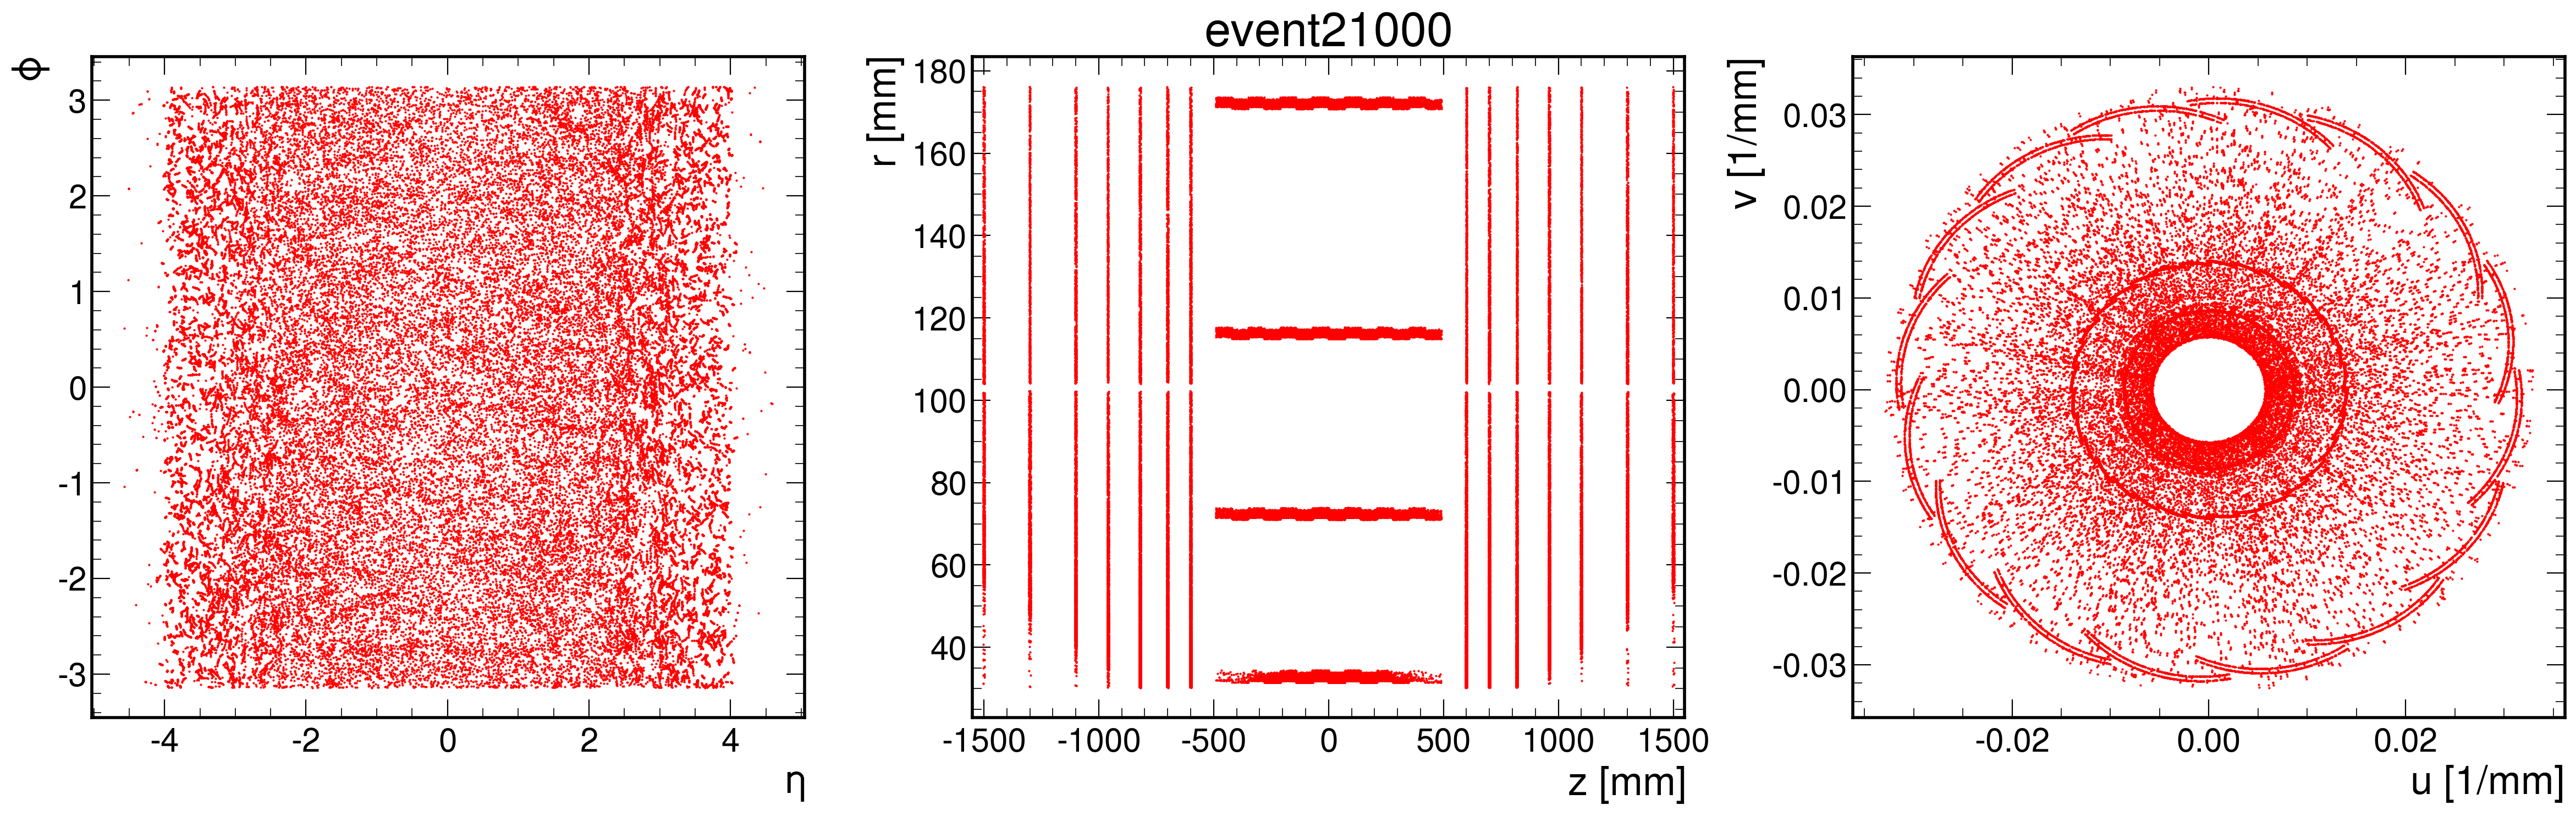

In [29]:
# visualize the sectors in each event and an overlapped ('extended') sector
pc_plotter = PointCloudPlotter(
    data_path.parent / "point_clouds" / "generated",
    n_sectors=pc_builder.n_sectors,
)
pc_plotter.plot_ep_rv_uv_all_sectors(evtid)

In total, we have 9000 data files, so we have wrapped the above conversion command into some command line utilities that you can find in [the main package](https://github.com/gnn-tracking/gnn_tracking/tree/main/src/gnn_tracking/preprocessing).

In particular, take a look at the `build_point_clouds.py` command line script. We have also provided an example SLURM script to dispatch this on the servers.

If you are working on della, we have already done all the preprocessing for you. All data is at `/scratch/gpfs/IOJALVO/gnn-tracking/object_condensation`. The `readme` contains some more information about the different versions, but it's probably best to ask Kilian.